# Parker wind model for planetary atmospheric escape

In this practical lesson we will learn how to model the upper atmosphere of a hot Jupiter following the approximation known as the **Parker wind** description ([Parker 1958](https://ui.adsabs.harvard.edu/abs/1958ApJ...128..664P/abstract); [Watson et al. 1981](https://ui.adsabs.harvard.edu/abs/1981Icar...48..150W/abstract)).

The Parker wind model was initially developed to describe the solar wind driven by mass loss from our own Sun. But it has also seen applications for atmospheric escape in exoplanets and accretion of material in protoplanetary disks.

This model assumes that the heating and cooling of escaping material is close to isothermal, and that the escaping material is spherically symmetric. It also ignores the effects of magnetic fields.

A time-independent wind with a constant mass-loss rate $\dot{M}$ follows the equation of mass conservation:

\begin{equation}
\dot{M} = 4 \pi r^2 \rho(r) v(r) \mathrm{,}\ \ [{\rm Eq.} 1]
\end{equation}where $r$ is the radius, $\rho$ is the density, and $v$ is the velocity of the outflow. For an isothermal wind, the momentum equation is:

\begin{equation}
v \frac{dv}{dr} + \frac{1}{\rho}\frac{dp}{dr} + \frac{G M_\mathrm{pl}}{r^2} = 0 \mathrm{,}
\end{equation}where $p$ is the momentum and $M_\mathrm{pl}$ is the planetary mass.

In the case of an isothermal wind with temperature $T_0$, the momentum equation has a singularity at the sonic point, where the velocity of the outflow matches the speed of sound $v_\mathrm{s}$, which is given by:

\begin{equation}
v_s = \sqrt{\frac{k_{\rm B}T_0}{\mu m_{\rm H}}} \mathrm{,}\ \ [{\rm Eq.} 2]
\end{equation}where $\mu$ is the mean molecular (or atomic) weight of the gas and $m_{\rm H}$ is the mass of one proton. The radius at the sonic point is

\begin{equation}
r_s = \frac{G M_\mathrm{pl}}{2 v_s^2}\ \ [{\rm Eq.} 3]
\end{equation}

Following [Lamers & Cassinelli (1999)](https://ui.adsabs.harvard.edu/abs/1999isw..book.....L/abstract), we derive the velocity profile of the outflow for an isothermal wind, which will be given by:

\begin{equation}
\frac{v(r)}{v_s}\exp{\left[-\frac{v^2(r)}{2v_s^2}\right]} = \left(\frac{r_s}{r} \right)^2 \exp{\left(-\frac{2r_s}{r} + \frac{3}{2} \right)} \mathrm{.}\ \ [{\rm Eq.} 4]
\end{equation}

Using the mass continuity equation, the resulting formula for the density profile will be:

\begin{equation}
\frac{\rho (r)}{\rho_s} = \exp{\left[ \frac{2r_s}{r} - \frac{3}{2} - \frac{v^2(r)}{2 v_s^2} \right]} \mathrm{.} \ \ [{\rm Eq.} 5]
\end{equation}

We will use equations 1 to 5 to calculate the structure of the upper atmosphere of the hot Jupiter HD 209458 b.

In [1]:
# First import the necessary packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import scipy.optimize as so
import astropy.constants as con
import astropy.units as u

pylab.rcParams['figure.figsize'] = 9.0,6.5
pylab.rcParams['font.size'] = 18

HD 209458 b is probably the most well known hot Jupiter among exoplanet scientists. It was the first transiting planet discovered, and it has been studied countless times. The next step is to fill in the physical properties of the planet. I suggest you fetch the planetary properties from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html), but feel free to use any other source.

In [2]:
R_pl = 1.38 # Planetary radius; recommended unit: Jupiter radii
M_pl = 0.69  # Planetary mass; recommended unit: Jupiter mass
a_pl =  0.04747 # Semi-major axis of the orbit; recommended unit: astronomical unit (au)

The next parameters are in principle unknown, so we have to assume them. But they have been previously estimated in the literature (e.g. [Salz et al. 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...586A..75S/abstract)), so we are making a very educated guess here. To find the values of the mass loss rate `m_dot`, take a look at Table 3 of [Salz et al. 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...586A..75S/abstract). For the temperature `T_0`, assume an isothermal value based on Fig. 5 of that paper.

In [3]:
m_dot = np.exp(10.27) # Planetary mass loss rate (assumed) in g / s
T_0 = 5000  # Atmospheric temperature (assumed) in K

The next step can be tricky: calculating the mean molecular weight of the outflowing gas. It depends on the chemical composition of the gas and its ionization state. For now, let's assume the gas is 100% hydrogen and 100% neutral (atomic).

But you should already start asking yourself: What is the mean molecular weight of a gas that is 90% hydrogen and 10% helium? What if the hydrogen is 70% ionized? Hint: Remember that ionization of hydrogen introduces free electrons in the gas, and they count towards the number of particles (but not mass, because their mass is many order of magnitudes lower than the proton)

In [4]:
mu = 1  # Mean atomic weight of a particle in the gas (unitless)
m_h = 1.67262192369e-27  # Hydrogen mass in kg

With all the setup done, we can start calculating the structure of the atmosphere.

In [5]:
# For the physical constants use whatever units you prefer, but naturally 
# they have to be consistent! The way I setup the units here, the sound speed 
# will come out in km / s and the radius of the sonic point in Jupiter radii if 
# you used the units I recommended for everything above. Unit conversion is a 
# pain, but they are necessary to avoid numerical overflows when performing 
# numerical calculations. Also, astronomers use weird units anyway.

k_b = 1.380649e-29  # Boltzmann constant in km ** 2 / s ** 2 * kg / K
G = 1772.0378503888546  # Gravitational constant in unit of
                        # jupiterRad * km ** 2 / s ** 2 / jupiterMass
rjup = (con.R_jup.to(u.cm)).value # Radius of Jupiter in cm

# Equation 2: v_s would be in km/s
def sound_speed(temperature, mean_molecular_weight):
    v_s = np.sqrt(k_b * temperature / mean_molecular_weight / m_h)
    return v_s

# Equation 3: r_s would be in R_jup
def radius_sonic_point(planet_mass, sound_speed_0):
    r_s = G * planet_mass / 2 / sound_speed_0 ** 2
    return r_s

# Equation 1 (density would come out in g / cm ** 3)
def density_sonic_point(mass_loss, rad_son_pt, cs):
    rad1 = rad_son_pt*rjup
    cs1 = cs*1e5
    den = mass_loss / (4 * np.pi * (rad1**2) * cs)
    return den
    # Write your own function here

v_s =  sound_speed(T_0, mu)# Speed of sound in km / s
print('Sound speed (in km/s): ', v_s)
r_s =  radius_sonic_point(M_pl, v_s)# Radius of the sonic point in Jupiter radii
print('Radius of the sonic point (in R_jup): ', r_s)
rho_s = density_sonic_point(m_dot, r_s, v_s) # Density at the sonic point in g / cm ** 3
print('Density at the sonic point (in g/cm3): ', rho_s)

Sound speed (in km/s):  6.424328664041565
Radius of the sonic point (in R_jup):  14.812780490454415
Density at the sonic point (in g/cm3):  3.186974925162931e-20


The next step to model the atmospheric structure is to calculate the velocity and density profiles of the outflowing material using Equations 4 and 5. This is the most challenging part of the exercise. 

The reason is because Eq. 4 is transcedental, so we need to use a numerical method. My recommendation is to use one of the functions in the `scipy.optimize` package to perform this calculation. Furthermore, it has many solutions. Naturally we are interested in the the solution that reflects an expanding wind, i.e., velocity increasing smoothly and asymptotically with radius.

One thing to keep in mind is that numerical algorithms usually require a first guess, and this first guess will influence the final solution. Give a lot of attention to your first guess, and how it makes sense with the solution you get.

In [6]:
# Here's how I would start it
def eq_to_solve(v, rk):
    # v is the velocity in km / s
    # r is the radius in Jupiter radii
    abc = (v / v_s) * np.exp(-0.5 * (v / v_s) ** 2) - (r_s / rk) ** 2 * \
        np.exp(-2 * r_s / rk + 3 / 2)
    #cdf = np.abs(abc)
    return abc

# Next we define our grid of radii in units of Jupiter radii, starting from the
# base of the atmosphere at R_pl, and going to 15 Jupiter radii, sampling 500 
# points
r = np.linspace(R_pl, 15, 500)

# Now it's your turn

def den_r(velo, rad):
    ab = 2*r_s/rad
    bc = 0.5*((velo/v_s)**2)
    abc = rho_s*np.exp(ab - 1.5 - bc)
    return abc

v_r = np.zeros(len(r))

for i in range(len(r)):
    vr1 = so.newton(eq_to_solve, x0=0, args=[r[i]])# Velocity in function of radius
    v_r[i] = vr1

rho_r =  den_r(v_r, r)# Density in function of radius

#print(rho_r)

In [7]:
# Also, you might find the next function useful
def nearest_index(array, target_value):
    """
    Finds the index of a value in ``array`` that is closest to ``target_value``.
    Parameters
    ----------
    array (``numpy.array``):
        Target array.
    target_value (``float``):
        Target value.
    Returns
    -------
    index (``int``):
        Index of the value in ``array`` that is closest to ``target_value``.
    """
    index = array.searchsorted(target_value)
    index = np.clip(index, 1, len(array) - 1)
    left = array[index - 1]
    right = array[index]
    index -= target_value - left < right - target_value
    return index

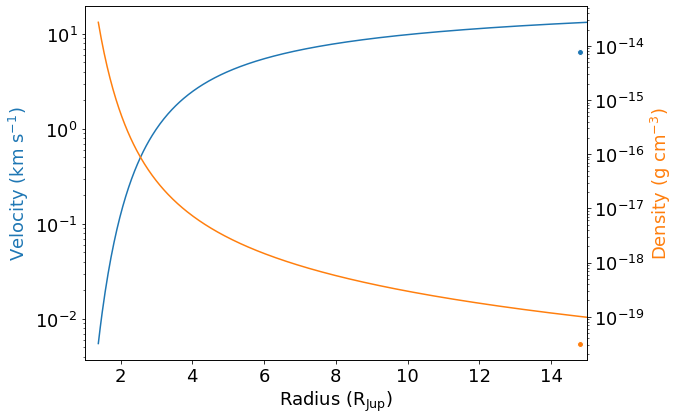

In [8]:
# You should get results similar to the following, but it is fine if they do
# not match completely
#!wget https://gist.githubusercontent.com/ladsantos/d6f4f1a6fe98903675a7bced598e1a70/raw/83c72b6a5090c7a08c0a299b9085e442e2072e29/result_v.txt
#!wget https://gist.githubusercontent.com/ladsantos/e0060d8b212ef174dd590b52e9f2953d/raw/9a38c74cf20ac0fbd7aa4d712432de3e976dc9bb/result_rho.txt

v_result = np.loadtxt('result_v.txt', usecols=(1,))
rho_result = np.loadtxt('result_rho.txt', usecols=(1,))

ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.semilogy(r, v_result, color='C0')
ax1.plot(r_s, v_s, marker='o', markeredgecolor='w', color='C0')
ax2.semilogy(r, rho_result, color='C1')
ax2.plot(r_s, rho_s, marker='o', markeredgecolor='w', color='C1')
ax1.set_xlabel(r'Radius (R$_{\rm Jup}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(1, 15)
plt.show()

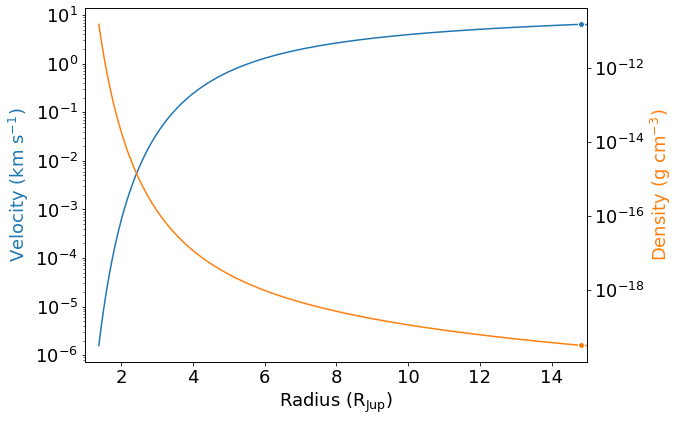

In [9]:
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.semilogy(r, v_r, color='C0')
ax1.plot(r_s, v_s, marker='o', markeredgecolor='w', color='C0')
ax2.semilogy(r, rho_r, color='C1')
ax2.plot(r_s, rho_s, marker='o', markeredgecolor='w', color='C1')
ax1.set_xlabel(r'Radius (R$_{\rm Jup}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(1, 15)
plt.show()

## Questions

Answer the following questions based on your results.

1. What happens with the structure of the atmosphere (velocities and densities) when we increase the atmospheric escape rate `m_dot`? And what if we increase the temperature `T_0` of the outflow? **Show your plots**.

*Answer:* I would say, by increasing the atmospheric escape rate (`m_dot`) and the temperature (`T_0`), the velocities and densities should increase, especially at high altitude. We would verify this claim by writing a function that takes mass loss rate and temperature as inputs and returns density and velocity proflies for given radius ranges.

In [10]:
def structure_mt(rad, mdot, t0, mu, mp):
    """
    Parameters:
    -----------
    rad : float, numpy.ndarray
        radius range for which the structure is needed
    mdot : float
        mass loss rate (in g/s)
    t0 : float
        temperature (in K)
    mu : float
        mean molecular weight
    mp : float
        mass of the planet
    -----------
    return
    -----------
    numpy.ndarray
        velocities (in km/s) for given radius range
    numpy.ndarray
        densities (in g/cm3) for given radius range
    """
    # sound speed
    cs = sound_speed(t0, mu)
    # radius at sonic point
    rsp = radius_sonic_point(mp, cs)
    # density at sonic point
    dst = density_sonic_point(mdot, rsp, cs)
    # Equation to solve for finding velocity structure
    def eq_to_solve1(v, rk):
        # v is the velocity in km / s
        # r is the radius in Jupiter radii
        abc = (v / cs) * np.exp(-0.5 * (v / cs) ** 2) - (rsp / rk) ** 2 * \
            np.exp(-2 * rsp / rk + 3 / 2)
        #cdf = np.abs(abc)
        return abc
    # for velocity structure
    vstr = np.zeros(len(rad))
    for i in range(len(rad)):
        vs1 = so.newton(eq_to_solve1, x0=0, args=[rad[i]])
        vstr[i] = vs1
    # for density structure
    denst = den_r(vstr, rad)
    return vstr, denst

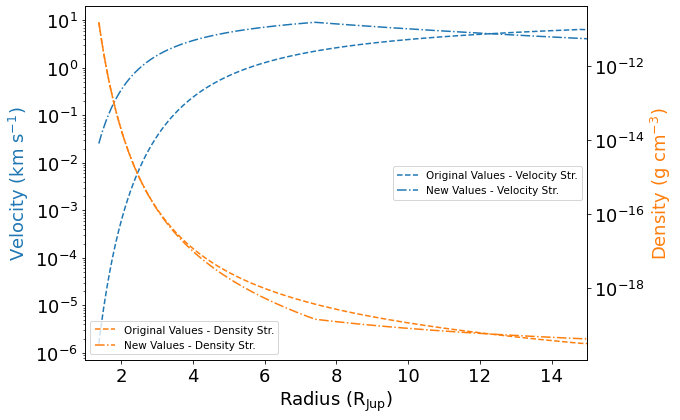

In [11]:
velo0, den0 = structure_mt(rad=r, mdot=m_dot, t0=T_0, mu=mu, mp=M_pl)
velo1, den1 = structure_mt(rad=r, mdot=2*m_dot, t0=2*T_0, mu=mu, mp=M_pl)

ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.semilogy(r, velo0, color='C0', ls='--', label='Original Values - Velocity Str.')
ax1.semilogy(r, velo1, color='C0', ls='-.', label='New Values - Velocity Str.')
ax1.legend(loc=7, fontsize='xx-small')
ax2.semilogy(r, den0, color='C1', ls='--', label='Original Values - Density Str.')
ax2.semilogy(r, den1, color='C1', ls='-.', label='New Values - Density Str.')
ax1.set_xlabel(r'Radius (R$_{\rm Jup}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(1, 15)
ax2.legend(loc=3, fontsize='xx-small')
plt.show()

Well, this is not what exactly I expected -- velocities, at lower altitudes, have larger values than the previous case, however, at higher altitudes they seems to converge at similar magnitudes. On the contrary, the density structure, in both of the cases, doesn't change much (except for intermediate altitudes).

2. How different would be the structure of the upper atmosphere of a warm Neptune like **GJ 436 b** compared to that of the hot Jupiter HD 209458 b? Assume an escape rate `m_dot` of 2E10 g / s, and temperature `T_0` of 5000 K.

*Answer: * GJ 436 b is a warm Neptune with much lower mass ($0.07 M_J$) than the hot Jupiter HD 209458 b. We expect to have much large mass loss with higher velocity and density structure. We test this hypothesis with the function `structure_mt` we created earlier.

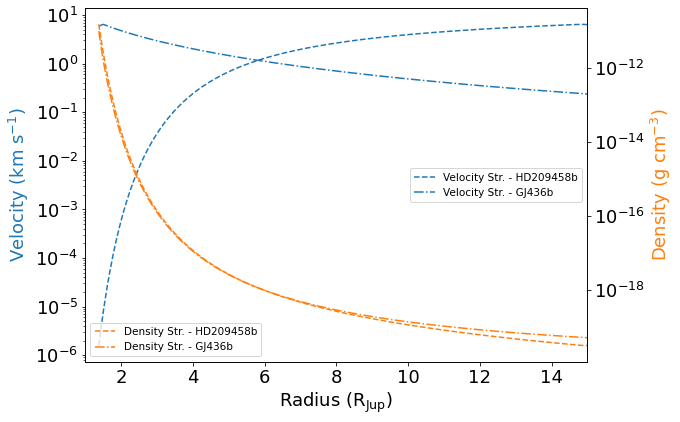

In [12]:
velo2, den2 = structure_mt(rad=r, mdot=2e10, t0=5000, mu=mu, mp=0.07)

ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.semilogy(r, velo0, color='C0', ls='--', label='Velocity Str. - HD209458b')
ax1.semilogy(r, velo2, color='C0', ls='-.', label='Velocity Str. - GJ436b')
ax1.legend(loc=7, fontsize='xx-small')
ax2.semilogy(r, den0, color='C1', ls='--', label='Density Str. - HD209458b')
ax2.semilogy(r, den2, color='C1', ls='-.', label='Density Str. - GJ436b')
ax1.set_xlabel(r'Radius (R$_{\rm Jup}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(1, 15)
ax2.legend(loc=3, fontsize='xx-small')
plt.show()

3. How would you calculate the mean molecular (or atomic) weight of the escaping gas assuming that it is composed of 10% helium, 90% hydrogen, and 70% of the hydrogen atoms are ionized?

*Answer: * To answer this question, let's derive a general formula for the mean molecular weight. The mean molecular weight is defined as the mass per free particle in unit of atomic mass. If $n$ is the number of free particles per unit volume then it is evident that, $n \mu m_H = \rho$, where $\mu$ is the mean molecular weight and $m_H$ is the mass of the hydrogen atom.

$$\Rightarrow n = \frac{\rho}{\mu m_H} \ \ \ \ \ ...[Eq.6]$$

If $X_j$ is the mass fraction of element $j$ in the mixture of the gas then $X_j \rho$ would be the mass of the element $j$ per unit volume. Since $A_jm_H$ is the total mass of one atom of species $j$, then,

$$\sum_j \frac{X_j \rho}{A_jm_H} (1 + E_j) \ \ \ \ \ ...[Eq.7]$$

would be the number of free particle per unit volume, where $E_j$ is the number of average electron coming from the $j^{th}$ element. $(1+E_j)$ term is there to account for the ionization (fraction) from element $j$.

We can now compare Eq. 6 and Eq. 7 and solve for $\mu$ to find the expression of the mean molecular weight, which can be written as follows,

$$\frac{1}{\mu} = \sum_j \frac{X_j}{A_j} (1+E_j)$$

We can now calculate the mean molecular weight for the given mixture of Hydrogen (with $A_H = 1$) and Helium (with $A_{He} = 4$), with $X_H = 0.9$, $X_{He} = 0.1$, $E_H = 0.77$ and $E_{He} = 0$,

$$\frac{1}{\mu} = \frac{0.9}{1} (1+0.77) + \frac{0.1}{4} (1+0) = 1.593+0.025 = 1.618$$

$$\Rightarrow \mu = 0.618$$

4. [*Challenge question*] How different is the sound speed in the atmosphere for the case of question 3? And how does the structure of the atmosphere (density and velocities) change for this case?

In [13]:
print('The sound speed (in km/s) if all of the material was pure neutral hydrogen: ', v_s)
v_s1 = sound_speed(T_0, 0.618)
print('The sound speed (in km/s) in the mixture of the gases: ', v_s1)

The sound speed (in km/s) if all of the material was pure neutral hydrogen:  6.424328664041565
The sound speed (in km/s) in the mixture of the gases:  8.172097010730662


This is, I would say, expected since the density of material would increase in case of the mixture of gases, making an increment in the sound speed. This can also be seen from the Eq. 2, where $v_s \propto \mu^{-1/2}$, therefore decreasing $\mu$ will lead to increment in the sound speed. Now, let's calculate the atmospheric structure for this case usind the function we created earlier.

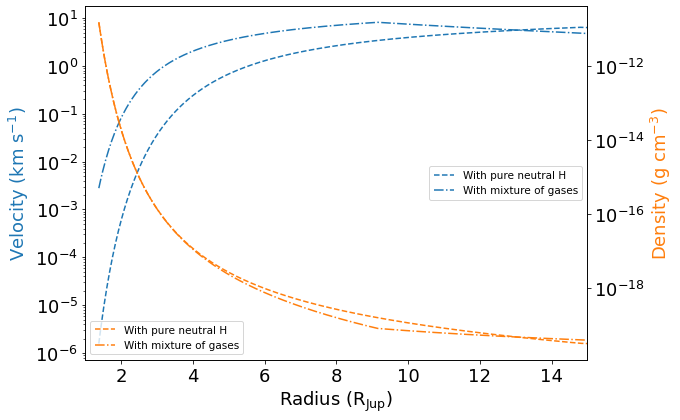

In [14]:
velo3, den3 = structure_mt(rad=r, mdot=m_dot, t0=T_0, mu=0.618, mp=M_pl)

ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.semilogy(r, velo0, color='C0', ls='--', label='With pure neutral H')
ax1.semilogy(r, velo3, color='C0', ls='-.', label='With mixture of gases')
ax1.legend(loc=7, fontsize='xx-small')
ax2.semilogy(r, den0, color='C1', ls='--', label='With pure neutral H')
ax2.semilogy(r, den3, color='C1', ls='-.', label='With mixture of gases')
ax1.set_xlabel(r'Radius (R$_{\rm Jup}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(1, 15)
ax2.legend(loc=3, fontsize='xx-small')
plt.show()

Well... it seems that the decrement in the mean molecular weight is increasing the velocities in the lower atmosphere, but not much change is observed in the upper atmosphere. On the other hand, the density structure remains the same for the most of the altitudes except intermediate altitudes (for some strange reasons!!)